In [1]:
import setGPU

import tensorflow as tf

import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import seaborn as sns
import pandas as pd
import bm3d, math

from feature_eng import *

setGPU: Setting GPU to: 0


/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3

### Load the csv file, separate the data based on different classes and check the no.of samples in each class ###

In [2]:
csv_file_path = '../data/gicsd_labels.csv'
src_data_path = '../data/images'

In [3]:
data = pd.read_csv(csv_file_path, header=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   IMAGE_FILENAME  800 non-null    object
 1    LABEL          800 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


In [4]:
""" creates the classes folder under data and sperate the data as different classes by reading entries from csv file """
paths = read_csv_file(csv_file_path, src_data_path)
paths

['../data/classes/FULL_VISIBILITY',
 '../data/classes/PARTIAL_VISIBILITY',
 '../data/classes/NO_VISIBILITY']

In [7]:
def display_samples_distribution(classes, each_class_samples):
    index = np.arange(len(classes))
    plt.bar(index, each_class_samples)
    plt.xlabel('classes', fontsize=5)
    plt.ylabel('No of samples', fontsize=8)
    plt.xticks(index, classes, fontsize=8, rotation=30)
    plt.title('No of samples in each class')
    plt.show()

2584 2214 2790


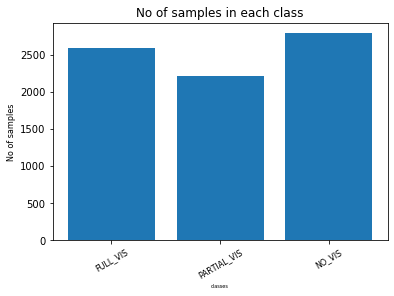

In [8]:
""" plot the samples in each category """

fv_path = paths[0]
pv_path = paths[1]
nv_path = paths[2]

images_fv = os.listdir(fv_path)
images_pv = os.listdir(pv_path)
images_nv = os.listdir(nv_path)
print(len(images_fv), len(images_pv), len(images_nv))

classes=['FULL_VIS', 'PARTIAL_VIS', 'NO_VIS']
each_class_samples = [len(images_fv), len(images_pv), len(images_nv)]

display_samples_distribution(classes, each_class_samples)

### Analyse a few samples in each category visually to check the noise level and plot distribution of each sample channels from each class

In [7]:
def display_images(images_fv, images_pv, images_nv, n):
    plt.figure(figsize=(24,4))
    for i in range(n):
        ax = plt.subplot(3, n, i+1)
        if i == 0:
            plt.title('fv_images', fontsize=12)
        plt.imshow(images_fv[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i+1+n)
        if i == 0:
            plt.title('pv_images', fontsize=12)
        plt.imshow(images_pv[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        ax = plt.subplot(3, n, i+1+2*n)
        if i == 0:
            plt.title('nv_images', fontsize=12)
        plt.imshow(images_nv[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

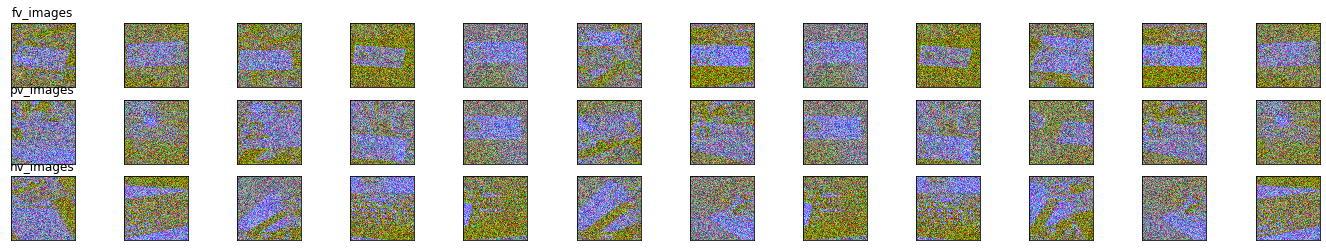

In [8]:
""" read a few samples from each category and dsiplay them """
raw_images_fv = []
raw_images_pv = []
raw_images_nv = []
n = 12
for i in range(n):
    rInd = np.random.randint(0, len(images_nv)-1)
    raw_images_fv.append(cv.cvtColor(cv.imread(os.path.join(fv_path, images_fv[rInd])), cv.COLOR_BGR2RGB))
    raw_images_pv.append(cv.cvtColor(cv.imread(os.path.join(pv_path, images_pv[rInd])), cv.COLOR_BGR2RGB))
    raw_images_nv.append(cv.cvtColor(cv.imread(os.path.join(nv_path, images_nv[rInd])), cv.COLOR_BGR2RGB))
    
display_images(raw_images_fv, raw_images_pv, raw_images_nv, n)

In [9]:
def display_img_3channel_hist(img):
    plt.subplot(221), plt.imshow(img), plt.axis('off')
    color = ('b','g','r')
    plt.subplot(222)
    plt.axis('off')
    for i,col in enumerate(color):
        histr = cv.calcHist([img],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    plt.show()

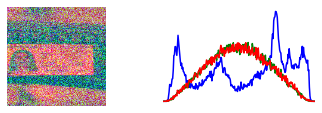

In [10]:
""" dispaly full visibility image and it's pixels distribution """

img = cv.imread(os.path.join(fv_path, images_fv[0]))
display_img_3channel_hist(img)

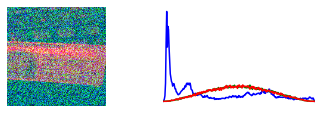

In [11]:
""" dispaly partial visibility image and it's pixel distribution """

img = cv.imread(os.path.join(pv_path, images_pv[0]))
display_img_3channel_hist(img)

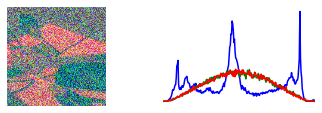

In [12]:
""" dispaly no visibility image and it's pixel distribution """

img = cv.imread(os.path.join(nv_path, images_nv[0]))
display_img_3channel_hist(img)

### Anaylise single image to check the noise level apply noise reduction algorithm in case if that helps and analyse each channel ###

In [13]:
def display_single_image(img, title):
    plt.imshow(img)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

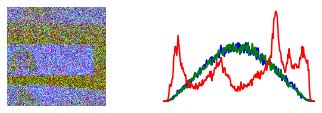

In [14]:
img = cv.cvtColor(cv.imread(os.path.join(fv_path, images_fv[0])), cv.COLOR_BGR2RGB)
display_img_3channel_hist(img)

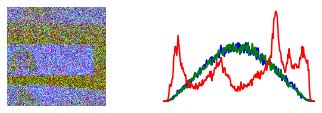

In [15]:
denoised_image = bm3d.bm3d(img + 0.5, sigma_psd=30/255, stage_arg=bm3d.BM3DStages.ALL_STAGES)#HARD_THRESHOLDING)
d_img = denoised_image.astype(np.uint8)

display_img_3channel_hist(d_img)

In [16]:
def display_img_1channel_hist(img):
    plt.subplot(221)
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(222)
    plt.axis('off')
    histr = cv.calcHist([img], [0], None, [256], [0,256])
    plt.plot(histr)
    plt.xlim([0,256])
    plt.show()

original image shape:(192, 192, 3), single channel shape:(192, 192)


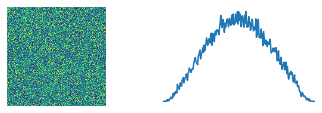

In [17]:
r, g, b = cv.split(img)
print("original image shape:{}, single channel shape:{}".format(img.shape, b.shape))
display_img_1channel_hist(r)

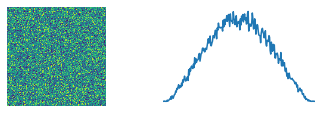

In [18]:
display_img_1channel_hist(g)

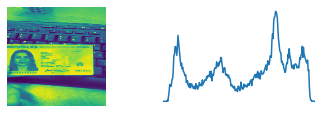

In [19]:
display_img_1channel_hist(b)

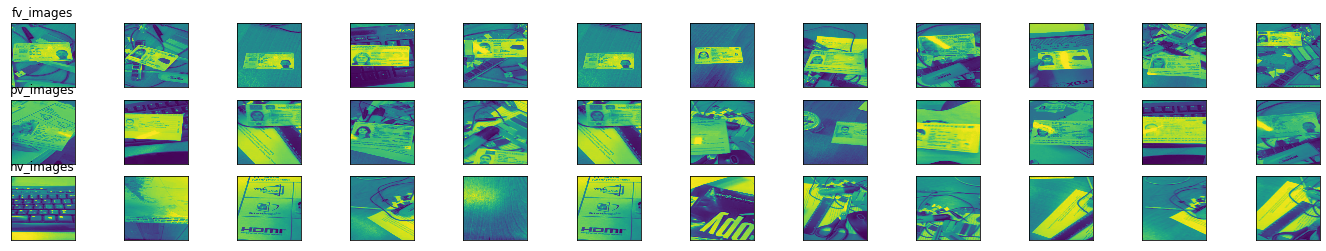

In [20]:
raw_images_fv = []
raw_images_pv = []
raw_images_nv = []
n = 12
for i in range(n):
    rInd = np.random.randint(0, len(images_nv)-1)
    raw_images_fv.append(get_single_channel_image(os.path.join(fv_path, images_fv[rInd])))
    raw_images_pv.append(get_single_channel_image(os.path.join(pv_path, images_pv[rInd])))
    raw_images_nv.append(get_single_channel_image(os.path.join(nv_path, images_nv[rInd])))
    
display_images(raw_images_fv, raw_images_pv, raw_images_nv, n)

### Over-sampling by applying data augmentation ###

In [21]:
fv_aug_data_path = '../data/aug_data/FULL_VISIBILITY'
nv_aug_data_path = '../data/aug_data/NO_VISIBILITY'
pv_aug_data_path = '../data/aug_data/PARTIAL_VISIBILITY'

roperation = 'rotation'
boperation = 'brightness'
zoperation = 'zoom'

In [22]:
""" Augment data with different techniques and save them """

da_obj = data_augmentation()

""" FULL visibaility data augmentation """
class_type = 'full_vis'

fv_angles = [90]
da_obj.trigger_augmentation(fv_aug_data_path, fv_path, fv_angles, class_type, roperation) #rotation
fv_angles = [0]
da_obj.trigger_augmentation(fv_aug_data_path, fv_path, fv_angles, class_type, boperation) #brightness
da_obj.trigger_augmentation(fv_aug_data_path, fv_path, fv_angles, class_type, zoperation) #zoom

""" NO visibility data augmentation """
class_type = 'no_vis'

nv_angles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170]
da_obj.trigger_augmentation(nv_aug_data_path, nv_path, nv_angles, class_type, roperation) #rotation
nv_aug_data_path_n = os.path.join(nv_aug_data_path, roperation)
da_obj.merge_original_rotated_data(nv_aug_data_path_n, nv_path)

nv_angles = [0]
da_obj.trigger_augmentation(nv_aug_data_path, nv_path, nv_angles, class_type, boperation) #brightness
da_obj.trigger_augmentation(nv_aug_data_path, nv_path, nv_angles, class_type, zoperation) #zoom

""" partial visibility data augmentation  """
class_type = 'partial_vis'

pv_angles = [30, 60, 90, 120, 150]
da_obj.trigger_augmentation(pv_aug_data_path, pv_path, pv_angles, class_type, roperation) #rotation
pv_aug_data_path_n = os.path.join(pv_aug_data_path, roperation)
da_obj.merge_original_rotated_data(pv_aug_data_path_n, pv_path)

pv_angles = [0]
da_obj.trigger_augmentation(pv_aug_data_path, pv_path, pv_angles, class_type, boperation) #brightness
da_obj.trigger_augmentation(pv_aug_data_path, pv_path, pv_angles, class_type, zoperation) #zoom

In [23]:
""" merge original and augmented images """
da_obj = data_augmentation()

""" merge full visibility class data"""
fv_aug_data_path_r = os.path.join(fv_aug_data_path, roperation) #rotated data
da_obj.merge_original_rotated_data(fv_aug_data_path_r, fv_path)

fv_aug_data_path_b = os.path.join(fv_aug_data_path, boperation) #brightness data
da_obj.merge_original_rotated_data(fv_aug_data_path_b, fv_path)

fv_aug_data_path_z = os.path.join(fv_aug_data_path, zoperation) #zoom data
da_obj.merge_original_rotated_data(fv_aug_data_path_z, fv_path)

""" merge no-visibility class data, skipping rotoation as already merged while augmenting in case no and partial visibility """
nv_aug_data_path_b = os.path.join(nv_aug_data_path, boperation) #brightness data
da_obj.merge_original_rotated_data(nv_aug_data_path_b, nv_path)

nv_aug_data_path_z = os.path.join(nv_aug_data_path, zoperation) #zoom data
da_obj.merge_original_rotated_data(nv_aug_data_path_z, nv_path)

""" merge partial-visibility class data"""
pv_aug_data_path_b = os.path.join(pv_aug_data_path, boperation) #brightness data
da_obj.merge_original_rotated_data(pv_aug_data_path_b, pv_path)

pv_aug_data_path_z = os.path.join(pv_aug_data_path, zoperation) #zoom data
da_obj.merge_original_rotated_data(pv_aug_data_path_z, pv_path)

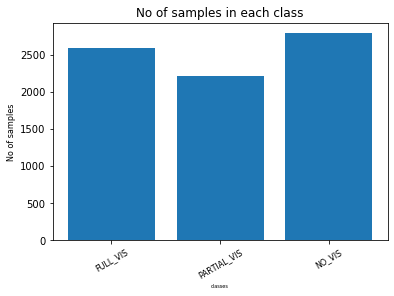

In [9]:
classes=['FULL_VIS', 'PARTIAL_VIS', 'NO_VIS']

each_class_samples = [len(os.listdir(fv_path)), len(os.listdir(pv_path)), len(os.listdir(nv_path))]
display_samples_distribution(classes, each_class_samples)

### Single channels images - extract sharp data from noisy data and dump them as separate files ###

In [11]:
""" create paths for single channel images with classes present"""

fv_single_channel_images_path = '../data/single_channel_images/FULL_VISIBILITY'
if not os.path.exists(fv_single_channel_images_path):
    os.makedirs(fv_single_channel_images_path)

pv_single_channel_images_path = '../data/single_channel_images/PARTIAL_VISIBILITY'
if not os.path.exists(pv_single_channel_images_path):
    os.makedirs(pv_single_channel_images_path)

nv_single_channel_images_path = '../data/single_channel_images/NO_VISIBILITY'
if not os.path.exists(nv_single_channel_images_path):
    os.makedirs(nv_single_channel_images_path)

In [12]:
"""Extract single channel images and store them in the created files"""

""" full_visibility files path """
extract_single_channel_image(fv_path, fv_single_channel_images_path)
    
""" partial_visibility files path """
extract_single_channel_image(pv_path, pv_single_channel_images_path)
    
""" no_visibility files path """
extract_single_channel_image(nv_path, nv_single_channel_images_path)

In [10]:
""" check the distribution of single channel images"""
classes=['FULL_VIS', 'PARTIAL_VIS', 'NO_VIS']
each_class_samples = [len(os.listdir(fv_single_channel_images_path)), len(os.listdir(pv_single_channel_images_path)), 
                      len(os.listdir(nv_single_channel_images_path))]
display_samples_distribution(classes, each_class_samples)

NameError: name 'fv_single_channel_images_path' is not defined

### Load augmented data, split as 60% train data, 20% validation data and 20% as testing data ###

In [28]:
single_channel_data_path = '../data/single_channel_images'
sci_tvt_path = '../data/sci_tvt/'
ds_obj = data_split(single_channel_data_path)
ds_obj.split_data(sci_tvt_path)

1550 516 516 <class 'list'>
1328 442 442 <class 'list'>
1674 558 558 <class 'list'>


In [29]:
""" compute the PSNR to check noise level between noisy image and sharp image """
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse)) 
    return psnr 

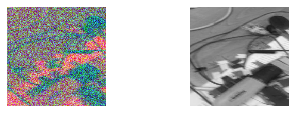

PSNR value is 29.667615079810346 dB


In [30]:
"""
r - is noise-less channel image
b - noisy channel image
"""
noisy_image_path = '../data/classes/NO_VISIBILITY/GICSD_8_7_213.png'
sharp_image_path = '../data/sci_tvt/test/NO_VISIBILITY/GICSD_8_7_213_SC.png'

noisy_img = cv.imread(noisy_image_path)
sharp_img = cv.imread(sharp_image_path)
plt.subplot(221), plt.imshow(noisy_img), plt.axis('off')
plt.subplot(222), plt.imshow(sharp_img), plt.axis('off'), plt.show()
value = PSNR(noisy_img, sharp_img) 
print(f"PSNR value is {value} dB")